In [25]:
import numpy as np
import math
from sympy import *
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Define all the variables
x = symbols("x")
x_bar = symbols(r"\bar{x}")
omega_0 = symbols(r"\omega_0", real = True)

# Define function: h_2n
def h_2n(n_val, x_val, x_bar_val, omega_0_val):
	return ((-1)**(n_val+1) * omega_0_val**2 / math.factorial(2*n_val)) * (1 / (2*omega_0_val))**n_val * (x_val + x_bar_val)**(2*n_val)

# Define the Hamiltonian function: h 
h = omega_0 * x * x_bar

for i in range(2,10):
	h += h_2n(i*2, x, x_bar, omega_0)

h

\bar{x}*\omega_0*x - (\bar{x} + x)**8/(645120*\omega_0**2) - (\bar{x} + x)**12/(30656102400*\omega_0**4) - (\bar{x} + x)**16/(5356234211328000*\omega_0**6) - (\bar{x} + x)**20/(2491291656372879360000*\omega_0**8) - (\bar{x} + x)**24/(2541356653499348743618560000*\omega_0**10) - (\bar{x} + x)**28/(4995290638118319890456641536000000*\omega_0**12) - (\bar{x} + x)**32/(17244542529286539193038799644917760000000*\omega_0**14) - (\bar{x} + x)**36/(97515818658011864751931247336052542668800000000*\omega_0**16)

<lambdifygenerated-10>:2: RuntimeWarning: overflow encountered in scalar power
  return 1j*(Dummy_52*x - 1/80640*(Dummy_53 + x)**7/Dummy_52**2 - 1/2554675200*(Dummy_53 + x)**11/Dummy_52**4 - 1/334764638208000*(Dummy_53 + x)**15/Dummy_52**6 - 1/124564582818643968000*(Dummy_53 + x)**19/Dummy_52**8 - 1/105889860562472864317440000*(Dummy_53 + x)**23/Dummy_52**10 - 1/178403237075654281802022912000000*(Dummy_53 + x)**27/Dummy_52**12 - 1/538891954040204349782462488903680000000*(Dummy_53 + x)**31/Dummy_52**14 - 1/2708772740500329576442534648223681740800000000*(Dummy_53 + x)**35/Dummy_52**16)
<lambdifygenerated-10>:2: RuntimeWarning: invalid value encountered in scalar multiply
  return 1j*(Dummy_52*x - 1/80640*(Dummy_53 + x)**7/Dummy_52**2 - 1/2554675200*(Dummy_53 + x)**11/Dummy_52**4 - 1/334764638208000*(Dummy_53 + x)**15/Dummy_52**6 - 1/124564582818643968000*(Dummy_53 + x)**19/Dummy_52**8 - 1/105889860562472864317440000*(Dummy_53 + x)**23/Dummy_52**10 - 1/178403237075654281802022912000000*(D

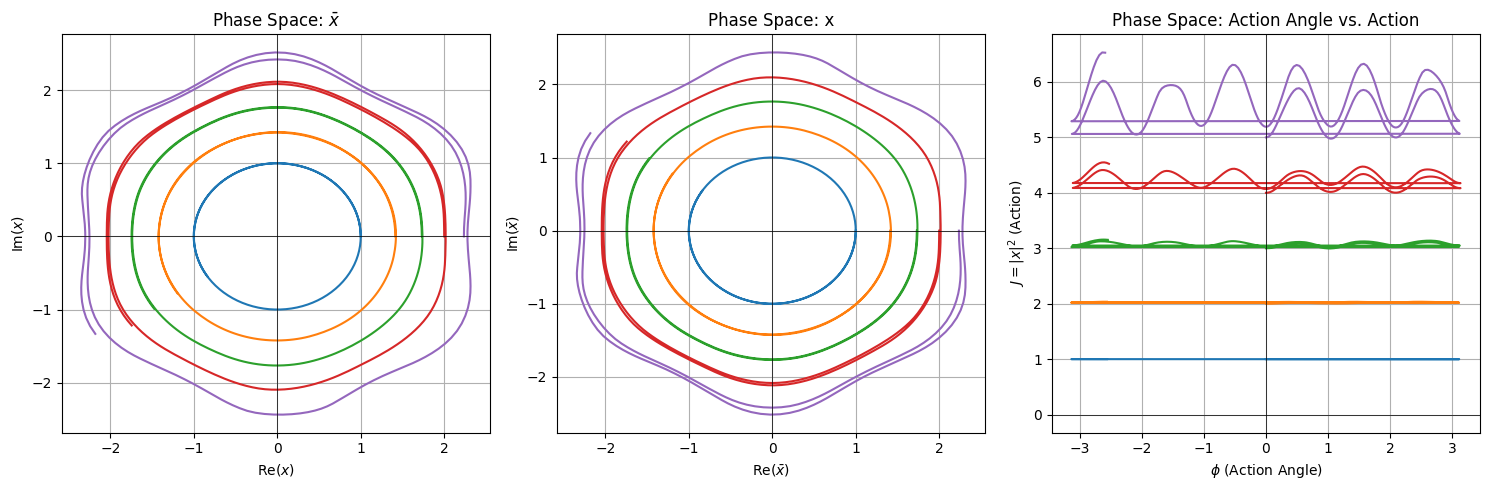

In [26]:
# Differentiate with respect to x and x_bar
difeq_x = lambdify([x, x_bar, omega_0], diff(h, x) * I)
difeq_x_bar = lambdify([x, x_bar, omega_0], diff(h, x_bar) * I)

# Natural frequency of the system
omega_0_val = 1.0

# Define the Hamiltonian system in terms of x and x bar
def hamiltonian_system(time, z):
    x, x_bar = z[0] + 1j * z[1], z[2] + 1j * z[3]  # Convert to complex form
    dxdt = difeq_x_bar(x, x_bar, omega_0_val)
    dx_bardt = difeq_x(x, x_bar, omega_0_val)
    return [dxdt.real, dxdt.imag, dx_bardt.real, dx_bardt.imag]

# Define different energy levels for hamiltonian
energy_levels = [1.0, 2.0, 3.0, 4.0, 5.0]

t_span = (0, 10)
t_eval = np.linspace(*t_span, 300)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i in range(len(energy_levels)):
    H = energy_levels[i]
    # Set initial condition for x and x̄ based on chosen 
	# energy H as sqrt(H/omega_0) with phase as 0
    x0 = np.sqrt(H/omega_0_val) * np.exp(0)
    x_bar0 = np.conj(x0)
    z0 = [x0.real, x0.imag, x_bar0.real, x_bar0.imag]

    # Solve the ODEs
    sol = solve_ivp(hamiltonian_system, t_span, z0, t_eval=t_eval)
    x_sol = sol.y[0] + 1j * sol.y[1]
    x_bar_sol = sol.y[2] + 1j * sol.y[3]

    # Compute action variable J and action angle phi
    J_sol = np.abs(x_sol) ** 2
    phi_sol = np.angle(x_sol)

    # Plot phase space for x
    axes[0].plot(x_sol.real, x_sol.imag)
    
	# Plot phase space for x_bar
    axes[1].plot(np.conj(x_sol).real, np.conj(x_sol).imag)

    # Plot angle space
    axes[2].plot(phi_sol, J_sol)
    
axes[0].set_xlabel(r'Re$(x)$')
axes[0].set_ylabel(r'Im$(x)$')
axes[0].set_title(r'Phase Space: $\bar{x}$')
axes[0].axhline(0, color='black', linewidth=0.5)
axes[0].axvline(0, color='black', linewidth=0.5)
axes[0].grid()

axes[1].set_xlabel(r'Re$(\bar{x})$')
axes[1].set_ylabel(r'Im$(\bar{x})$')
axes[1].set_title('Phase Space: x')
axes[1].axhline(0, color='black', linewidth=0.5)
axes[1].axvline(0, color='black', linewidth=0.5)
axes[1].grid()

axes[2].set_xlabel(r'$\phi$ (Action Angle)')
axes[2].set_ylabel(r'$J = |x|^2$ (Action)')
axes[2].set_title('Phase Space: Action Angle vs. Action')
axes[2].axhline(0, color='black', linewidth=0.5)
axes[2].axvline(0, color='black', linewidth=0.5)
axes[2].grid()

plt.tight_layout()
plt.show()
